In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

from pathlib import Path
#data_folder = Path("C:/Users/merri/OneDrive/Nan's NW/Capstone")

import numpy as np
import pandas as pd

import warnings
warnings.filterwarnings('ignore')


# import Natural Language Tookit
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

import matplotlib.pyplot as plt

import re

import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, BatchNormalization, Dropout, Flatten, Dense

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import tensorflow.keras.backend as k
from tensorflow.keras.metrics import AUC
from tensorflow.keras.models import load_model

from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.metrics import make_scorer, mean_squared_error
#from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.metrics import mean_squared_error as MSE

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc

from sklearn.feature_extraction.text import CountVectorizer

from packaging import version
from tensorflow.python.client import device_lib

# for BERT tokenization
# from transformers import BertTokenizer, TFAutoModel

from gensim.models import Word2Vec
from nltk.tokenize import word_tokenize

# for Glove tokenization
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import pad_sequences

# SMOTE oversampling
from imblearn.over_sampling import SMOTE

import joblib

In [2]:
print("This notebook requires TensorFlow 2.0 or above")
print("TensorFlow version: ", tf.__version__)
assert version.parse(tf.__version__).release[0] >=2

from tensorflow.python.client import device_lib
tf.config.list_physical_devices('GPU')

device_lib.list_local_devices()

This notebook requires TensorFlow 2.0 or above
TensorFlow version:  2.10.1


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 9643593819337621662
 xla_global_id: -1,
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 22385000448
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 14767145972273944753
 physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 4090, pci bus id: 0000:01:00.0, compute capability: 8.9"
 xla_global_id: 416903419]

In [3]:



# Download the stopwords and punkt tokenizer models
nltk.download('stopwords')
nltk.download('punkt')

# Function to determine the type of product number
def determine_number_type(s):
    if '.' in s:
        return 'float'
    elif '-' in s:
        return 'hyphenated'
    elif s.isdigit():  # checks if the string contains only numbers
        return 'numeric'
    else:
        return 'alphanumeric'

stop_words = set(stopwords.words('english'))

# Create a function to tokenize the Product_Description column based on the specified requirements:
# Convert underscores _ to spaces.
# Tokenize using spaces, commas, and other special characters.
# Filter out stopwords.
def combined_tokenizer(description):
    # Convert underscores to spaces
    description = description.replace("_", " ")

    # Tokenize based on spaces, commas, and other delimiters
    tokens = re.split(r'[ ,;()\n]+', description)

    # Tokenize further using alphanumeric boundaries
    refined_tokens = []
    for token in tokens:
        refined_tokens.extend(re.findall(r'\d+|\D+', token))
    
    # Filter out stopwords
    refined_tokens = [word for word in refined_tokens if word.lower() not in stop_words and len(word) > 1]

    return refined_tokens

# Assuming digits in Product_Description are refering to size/dimension of a product
# and may not play a significant role in classification.
# Remove digits and mean from a list of tokens and .

def remove_digits(tokens_list):
    return [token for token in tokens_list if not token.isdigit()]

def print_validation_report(y_test, predictions):
    print("Classification Report")
    print(classification_report(y_test, predictions))
    print('Accuracy Score: {}'.format(accuracy_score(y_test, predictions)))
    print('Root Mean Square Error: {}'.format(np.sqrt(MSE(y_test, predictions)))) 


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\reedb\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\reedb\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [4]:
# Import dataset
df=pd.read_csv('../Dataset/Commodity_Item_Master.csv')

# Delete the last two columns
df1 = df.drop(df.columns[-1:], axis = 1)

# Rename columns
columns = df1.columns.to_list() # NOTE: Commodity_Item_Master.csv has 'ï»¿Product #' column with non-alphanumeric characters; will rename to 'Product ID'
rename_dict = {
    columns[0]:'Product ID',
    columns[2]:'UNSPSC CODES',
    columns[3]:'UNSPSC Code Description'
}
df2 = df1.rename(columns = rename_dict)


# Delete rows with missing values
df3 = df2.dropna()

# Convert'UNSPSC CODES' from float to int
df3['UNSPSC CODES']=df3['UNSPSC CODES'].astype(int)

# Looks like row 294 has false UNSPSC Codes and UNSPSC Code Description, delete row 294
df4 = df3.drop(294)

# keep one row from the set of duplicated rows
df5 = df4.drop_duplicates(subset='Product ID', keep='first')

df5['ProductID_Type'] = df5['Product ID'].apply(determine_number_type)

### DESCRIPTIONS and Product ID
# Convert to lowercase for consistency
df5['DESCRIPTIONS']=df5['DESCRIPTIONS'].str.lower()
df5['Product ID']=df5['Product ID'].str.lower()

# Remove periods
df5['DESCRIPTIONS'] = df5['DESCRIPTIONS'].str.replace('.', '')
# ***** NOTE - PLEASE REVIEW: Do we need to remove periods to Product ID as well? *****
# df5['Product ID'] = df5['Product ID'].str.replace('.', '')

# Apply the function to the DESCRIPTIONS column
df5['TOKENS'] = df5['DESCRIPTIONS'].apply(combined_tokenizer)

# combine 'Product ID' and 'DESCRIPTIONS' columns into one column
df5['Product_Description'] = df5[['Product ID', 'DESCRIPTIONS']].apply(lambda x: ','.join(x), axis=1)

# Delete the row with '_na' as DESCRIPTIONS
df6 = df5[df5['DESCRIPTIONS']!='_na']


# Apply the function to the TOKENS column
df6['TOKENS'] = df6['TOKENS'].apply(remove_digits)

### UNSPSC Code Description
#### UNSPSC CODES_Segment Level
# Check how many types of Segments, which is the first level, in the UNSPSC CODES
# Convert UNSPSC CODES to string and extract the first two digits
df6['Segment'] = df6['UNSPSC CODES'].astype(str).str[:2]
df6['Family'] = df6['UNSPSC CODES'].astype(str).str[:4]
df6['Class'] = df6['UNSPSC CODES'].astype(str).str[:6]
df6['Commodity'] = df6['UNSPSC CODES'].astype(str).str[:8]

# Delete the only one entry that uses 811115035.
df6 = df6[df6['UNSPSC CODES'] != '811115035']

# Remove the string 'mm' from a list of tokens
df6['TOKENS'] = df6['TOKENS'].apply(lambda tokens: [token for token in tokens if token != 'mm'])


In [5]:
df6

,Product ID,DESCRIPTIONS,UNSPSC CODES,UNSPSC Code Description,ProductID_Type,TOKENS,Product_Description,Segment,Family,Class,Commodity
0,0,set up sheet for ccx600 d,55101516,Operation or instruction manuals,numeric,"[set, sheet, ccx]","0,set up sheet for ccx600 d",55,5510,551015,55101516
1,1000.004,"res, 270 ohm, cf, 1/8 w, 5%",32121706,Resistor or capacito,float,"[res, ohm, cf]","1000.004,res, 270 ohm, cf, 1/8 w, 5%",32,3212,321217,32121706
2,1000.005,"res, 200 ohm, cf, 1/8 w, 5%",32121706,Resistor or capacito,float,"[res, ohm, cf]","1000.005,res, 200 ohm, cf, 1/8 w, 5%",32,3212,321217,32121706
3,1000.06,"res, 56k, cf, 1/8 w, 5%",32121706,Resistor or capacito,float,"[res, cf]","1000.06,res, 56k, cf, 1/8 w, 5%",32,3212,321217,32121706
4,1000.075,"res, 100k, cf, 1/8 w, 5%",32121706,Resistor or capacito,float,"[res, cf]","1000.075,res, 100k, cf, 1/8 w, 5%",32,3212,321217,32121706
...,...,...,...,...,...,...,...,...,...,...,...
25167,z462358-14f,"36k,5%,1/16w,0402,lf",32121706,Resistor or capacito,hyphenated,[lf],"z462358-14f,36k,5%,1/16w,0402,lf",32,3212,321217,32121706
25168,z462358-42f,"res,1/16w,510k ohms,5%,0402",32121706,Resistor or capacito,hyphenated,"[res, ohms]","z462358-42f,res,1/16w,510k ohms,5%,0402",32,3212,321217,32121706
25169,z468610-04f,"c0g,15pf±025pf,50v,0201,lf",32121706,Resistor or capacito,hyphenated,"[pf±, pf, lf]","z468610-04f,c0g,15pf±025pf,50v,0201,lf",32,3212,321217,32121706
25170,z480086-01f,"side,actuated,16n,smd",39122221,Switch part or acces,hyphenated,"[side, actuated, smd]","z480086-01f,side,actuated,16n,smd",39,3912,391222,39122221


<Axes: ylabel='Commodity'>

19720

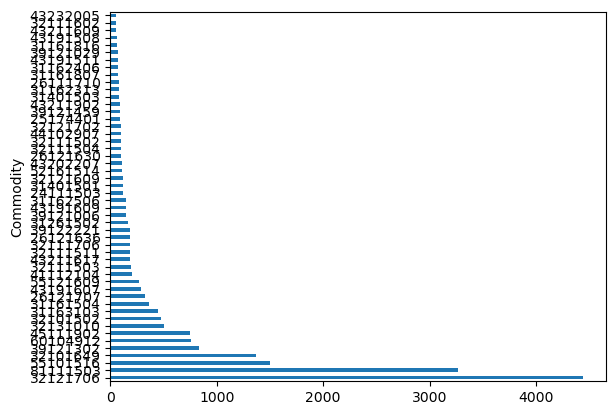

In [6]:
# get a dataframe of the top 50 Commodity CODES
y_top_50 = df6['Commodity'].value_counts().head(50)
df7 = df6[df6['Commodity'].isin(y_top_50.index.tolist())]
df7['Commodity'].value_counts().plot(kind='barh')

len(df7)

In [7]:
# Use label encoder to encode the Family CODES
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(df7['Commodity'])
# y_decoded = label_encoder.inverse_transform(y_encoded)

# Use one hot encoder to encode the Family CODES
one_hot_encoder = OneHotEncoder(sparse=False)
y_one_hot_encoded = one_hot_encoder.fit_transform(df7[['Commodity']])
# y_one_hot_decoded = one_hot_encoder.inverse_transform(y_one_hot_encoded)


In [37]:
df7['Commodity'].unique
print(df7['Commodity'].unique())


<bound method Series.unique of 0        55101516
1        32121706
2        32121706
3        32121706
4        32121706
           ...   
25167    32121706
25168    32121706
25169    32121706
25170    39122221
25171    39122221
Name: Commodity, Length: 19720, dtype: object>

['55101516' '32121706' '32111511' '32111504' '32111502' '39122221'
 '31163103' '39121459' '39121302' '31162506' '60104912' '31161504'
 '31161816' '43211617' '81111503' '31401501' '32101502' '41112104'
 '26121707' '26121630' '55121609' '24111503' '43191607' '39121029'
 '43211609' '39121006' '52161514' '31162406' '31161807' '43211902'
 '31261502' '32111706' '32111503' '32121702' '32131010' '44102907'
 '31162313' '43202207' '25174401' '45111902' '31401503' '32121609'
 '26121636' '32101649' '32111602' '26111710' '43191609' '43232005'
 '43191508' '43191511']


In [8]:
df7['Product_Description']

0                              0,set up sheet for ccx600 d
1                     1000.004,res, 270 ohm, cf, 1/8 w, 5%
2                     1000.005,res, 200 ohm, cf, 1/8 w, 5%
3                          1000.06,res, 56k, cf, 1/8 w, 5%
4                        1000.075,res, 100k, cf, 1/8 w, 5%
                               ...                        
25167                     z462358-14f,36k,5%,1/16w,0402,lf
25168              z462358-42f,res,1/16w,510k ohms,5%,0402
25169               z468610-04f,c0g,15pf±025pf,50v,0201,lf
25170                    z480086-01f,side,actuated,16n,smd
25171    z489516-01f,slide,1p3t,double-side recoil,smd-...
Name: Product_Description, Length: 19720, dtype: object

In [9]:
# Load the tfidf vectorizer
tfidf_vectorizer = joblib.load('tfidf_vectorizer_final.pkl')

X = tfidf_vectorizer.fit_transform(df7['Product_Description'])
X.shape


(19720, 24064)

In [10]:
tfidf_vectors = tfidf_vectorizer.inverse_transform(X)
df7['TF-IDF'] = list(tfidf_vectors)
df7 


,Product ID,DESCRIPTIONS,UNSPSC CODES,UNSPSC Code Description,ProductID_Type,TOKENS,Product_Description,Segment,Family,Class,Commodity,TF-IDF
0,0,set up sheet for ccx600 d,55101516,Operation or instruction manuals,numeric,"[set, sheet, ccx]","0,set up sheet for ccx600 d",55,5510,551015,55101516,"[ccx600, for, sheet, up, set]"
1,1000.004,"res, 270 ohm, cf, 1/8 w, 5%",32121706,Resistor or capacito,float,"[res, ohm, cf]","1000.004,res, 270 ohm, cf, 1/8 w, 5%",32,3212,321217,32121706,"[cf, ohm, 270, res, 004, 1000]"
2,1000.005,"res, 200 ohm, cf, 1/8 w, 5%",32121706,Resistor or capacito,float,"[res, ohm, cf]","1000.005,res, 200 ohm, cf, 1/8 w, 5%",32,3212,321217,32121706,"[200, 005, cf, ohm, res, 1000]"
3,1000.06,"res, 56k, cf, 1/8 w, 5%",32121706,Resistor or capacito,float,"[res, cf]","1000.06,res, 56k, cf, 1/8 w, 5%",32,3212,321217,32121706,"[56k, 06, cf, res, 1000]"
4,1000.075,"res, 100k, cf, 1/8 w, 5%",32121706,Resistor or capacito,float,"[res, cf]","1000.075,res, 100k, cf, 1/8 w, 5%",32,3212,321217,32121706,"[100k, 075, cf, res, 1000]"
...,...,...,...,...,...,...,...,...,...,...,...,...
25167,z462358-14f,"36k,5%,1/16w,0402,lf",32121706,Resistor or capacito,hyphenated,[lf],"z462358-14f,36k,5%,1/16w,0402,lf",32,3212,321217,32121706,"[14f, z462358, 36k, 0402, 16w, lf]"
25168,z462358-42f,"res,1/16w,510k ohms,5%,0402",32121706,Resistor or capacito,hyphenated,"[res, ohms]","z462358-42f,res,1/16w,510k ohms,5%,0402",32,3212,321217,32121706,"[42f, z462358, 510k, ohms, 0402, 16w, res]"
25169,z468610-04f,"c0g,15pf±025pf,50v,0201,lf",32121706,Resistor or capacito,hyphenated,"[pf±, pf, lf]","z468610-04f,c0g,15pf±025pf,50v,0201,lf",32,3212,321217,32121706,"[04f, z468610, 025pf, c0g, 15pf, 0201, lf, 50v]"
25170,z480086-01f,"side,actuated,16n,smd",39122221,Switch part or acces,hyphenated,"[side, actuated, smd]","z480086-01f,side,actuated,16n,smd",39,3912,391222,39122221,"[actuated, z480086, 01f, 16n, side, smd]"


In [11]:
# split X and y_one_hot_encoded into training test and validation sets
X_train_ohe, X_test_ohe, y_train_ohe, y_test_ohe = train_test_split(X, y_one_hot_encoded, test_size=0.1, random_state=42)
X_train_ohe, X_val_ohe, y_train_ohe, y_val_ohe = train_test_split(X_train_ohe, y_train_ohe, test_size=0.1, random_state=42)


In [12]:
# convert the true labels from one-hot encoded format to class labels
y_test_labels_ohe = one_hot_encoder.inverse_transform(y_test_ohe)

In [13]:
# # create the SMOTE object
smote_ohe = SMOTE()

# # fit and apply SMOTE to the one-hot-encoded training data
X_train_smote_ohe, y_train_smote_ohe = smote_ohe.fit_resample(X_train_ohe, y_train_ohe)

# # print the shape of the new training data
print('Shape of X_train_count_smote:', X_train_smote_ohe.shape)
print('Shape of y_train_smote:', y_train_smote_ohe.shape)


Shape of X_train_count_smote: (181950, 24064)
Shape of y_train_smote: (181950, 50)


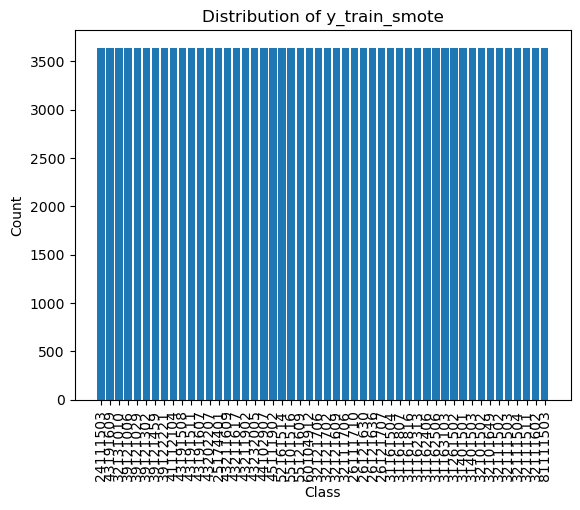

In [14]:
# import pandas as pd
# import matplotlib.pyplot as plt

# # create a dataframe of the class counts
class_counts = pd.DataFrame(one_hot_encoder.inverse_transform(y_train_smote_ohe), columns=['class']).value_counts().reset_index(name='count')

# plot the class counts as a bar chart
plt.bar(class_counts['class'], class_counts['count'])
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Distribution of y_train_smote')
plt.xticks(rotation=90)
plt.show();


In [15]:
# Load the saved model
model_02_tfidf_128 = load_model('best_model_02_tfidf_128.h5')
model_02_tfidf_128.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               3080320   
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 50)                6450      
                                                                 
Total params: 3,086,770
Trainable params: 3,086,770
Non-trainable params: 0
_________________________________________________________________


In [16]:
# # make predictions on the test data
pred_nn = model_02_tfidf_128.predict(X_test_ohe.toarray())

# # convert the predictions from one-hot encoded format to class labels
pred_nn_labels = one_hot_encoder.inverse_transform(pred_nn)

# generate a classification report
print_validation_report(y_test_labels_ohe, pred_nn_labels)

62/62 [==============================] - 1s 918us/step
Classification Report
              precision    recall  f1-score   support

    24111503       0.92      1.00      0.96        11
    25174401       1.00      1.00      1.00         6
    26111710       1.00      1.00      1.00         5
    26121630       0.86      0.60      0.71        10
    26121636       1.00      0.93      0.96        14
    26121707       0.93      0.96      0.95        28
    31161504       0.98      0.98      0.98        53
    31161807       1.00      0.75      0.86        12
    31161816       1.00      0.89      0.94         9
    31162313       0.71      0.83      0.77         6
    31162406       1.00      0.80      0.89        10
    31162506       1.00      1.00      1.00        14
    31163103       0.96      0.98      0.97        47
    31261502       0.93      1.00      0.97        14
    31401501       1.00      1.00      1.00        15
    31401503       1.00      1.00      1.00         8
    

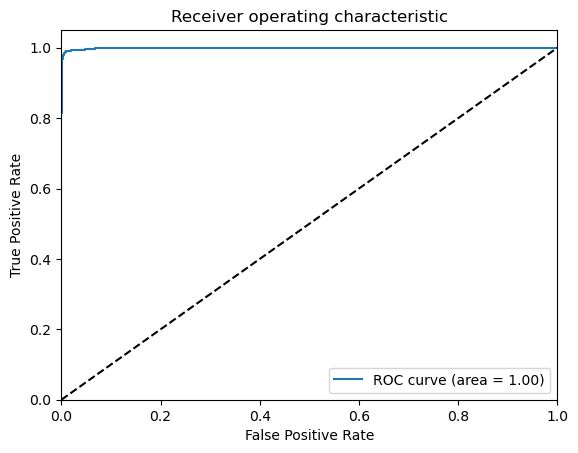

In [17]:
# calculate the false positive rate and true positive rate
fpr, tpr, thresholds = roc_curve(y_test_ohe.ravel(), pred_nn.ravel())

# calculate the area under the curve (AUC)
roc_auc = auc(fpr, tpr)

# plot the ROC curve
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show();


In [18]:
# create training, validation, and testing sets
X_train_enc, X_test_enc, y_train_enc, y_test_enc = train_test_split(X, y_encoded, test_size=0.1, random_state=42)
X_train_enc, X_val_enc, y_train_enc, y_val_enc = train_test_split(X_train_enc, y_train_enc, test_size=0.1, random_state=42)


In [19]:
# convert the true labels from one-hot encoded format to class labels
y_test_labels_enc = label_encoder.inverse_transform(y_test_enc)

In [20]:
# create the SMOTE object
smote_enc = SMOTE()

# fit and apply SMOTE to the training data
X_train_smote_enc, y_train_smote_enc = smote_enc.fit_resample(X_train_enc, y_train_enc)

# print the shape of the new training data
print('Shape of X_train_count_smote:', X_train_smote_enc.shape)
print('Shape of y_train_smote:', y_train_smote_enc.shape)


Shape of X_train_count_smote: (181950, 24064)
Shape of y_train_smote: (181950,)


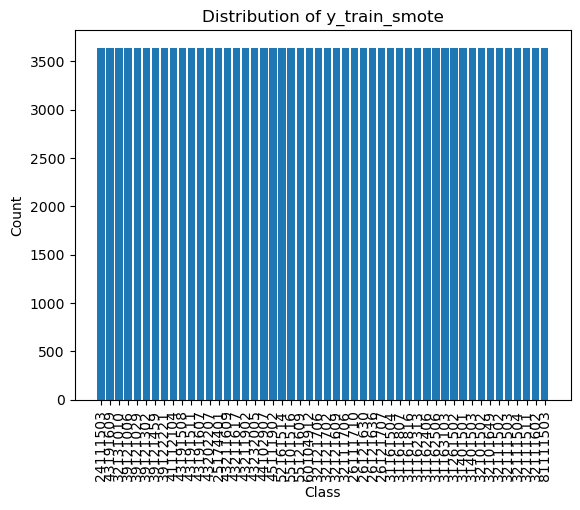

In [21]:
# create a dataframe of the class counts
class_counts = pd.DataFrame(label_encoder.inverse_transform(y_train_smote_enc), columns=['class']).value_counts().reset_index(name='count')

# plot the class counts as a bar chart
plt.bar(class_counts['class'], class_counts['count'])
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Distribution of y_train_smote')
plt.xticks(rotation=90)
plt.show();


In [22]:
# Load the saved model
logreg_best_model = joblib.load('logreg_best_model.pkl')

In [23]:
# Get the hyperparameters of the model
hyperparameters_logreg = logreg_best_model.get_params()

# Print the hyperparameters
hyperparameters_logreg

{'C': 100,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 100,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': None,
 'solver': 'lbfgs',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

In [24]:
# Use the loaded model to make predictions on new data
pred_logreg = logreg_best_model.predict(X_test_enc)
pred_logreg_decoded = label_encoder.inverse_transform(pred_logreg)
print_validation_report(y_test_labels_enc, pred_logreg_decoded)


Classification Report
              precision    recall  f1-score   support

    24111503       0.92      1.00      0.96        11
    25174401       1.00      1.00      1.00         6
    26111710       1.00      1.00      1.00         5
    26121630       0.78      0.70      0.74        10
    26121636       1.00      0.93      0.96        14
    26121707       0.87      0.96      0.92        28
    31161504       1.00      1.00      1.00        53
    31161807       1.00      0.83      0.91        12
    31161816       1.00      0.89      0.94         9
    31162313       0.83      0.83      0.83         6
    31162406       1.00      0.90      0.95        10
    31162506       1.00      1.00      1.00        14
    31163103       0.98      0.98      0.98        47
    31261502       0.93      1.00      0.97        14
    31401501       0.94      1.00      0.97        15
    31401503       1.00      0.88      0.93         8
    32101502       0.86      0.98      0.92        50
    3

In [25]:
def predict_unspsc_code_lr(product_id, description):
    product_description = ','.join([product_id, description])

    # Vectorize the product_description using the TF-IDF vectorizer
    vectorized_tokens = tfidf_vectorizer.transform([product_description])
    
    # Make predictions using the trained model
    predictions = logreg_best_model.predict(vectorized_tokens)
    
    # Convert the predictions from one-hot encoded format to class labels
    predicted_labels = label_encoder.inverse_transform(predictions)
    
    return predicted_labels[0]



In [26]:
def predict_unspsc_code_nn(product_id, description):
    product_description = ','.join([product_id, description])

    # Vectorize the product_description using the TF-IDF vectorizer
    vectorized_tokens = tfidf_vectorizer.transform([product_description])

    # Make predictions using the trained model
    predictions = model_02_tfidf_128.predict(vectorized_tokens.toarray())

    # Convert the predictions from one-hot encoded format to class labels
    predicted_labels = one_hot_encoder.inverse_transform(predictions)

    return predicted_labels[0][0]


In [81]:
product_id = 'ER-CR000W0402J5-C'
description = '0 Ohm;1/16 W;0402;+/-5%;=2;=2;AI=No;'
unspsc_code = '32121706'

# product_id = '2457-68644-001'
# description = 'CBL,ITP,LIFT SWT,SAM,XLR4,11'
# unspsc_code = '60104912'


In [82]:
result_lr = predict_unspsc_code_lr(product_id, description)
print(result_lr)


32121706


In [83]:
result_nn = predict_unspsc_code_nn(product_id, description)
print(result_nn)


1/1 [==============================] - 0s 12ms/step
32121706


In [49]:
vectorized_tokens_df6 = tfidf_vectorizer.transform(df6['Product_Description'])

Test Full Data DF6 on Best Logistic Regression Model:

In [53]:
# Make predictions using the trained model
pred_df6_lr = logreg_best_model.predict(vectorized_tokens_df6)

# Convert the predictions from one-hot encoded format to class labels
pred_df6_labels_lr = label_encoder.inverse_transform(pred_df6_lr)

print_validation_report(df6['Commodity'], pred_df6_labels_lr)


Classification Report
              precision    recall  f1-score   support

    13111308       0.00      0.00      0.00        19
    14111537       0.00      0.00      0.00         2
    14121504       0.00      0.00      0.00        28
    15121902       0.00      0.00      0.00         2
    23153130       0.00      0.00      0.00         2
    24111503       0.90      1.00      0.95       122
    24121502       0.00      0.00      0.00        26
    24121503       0.00      0.00      0.00        13
    24121507       0.00      0.00      0.00         2
    24121509       0.00      0.00      0.00         6
    24141514       0.00      0.00      0.00         8
    24141516       0.00      0.00      0.00         1
    24141709       0.00      0.00      0.00         5
    25174401       0.94      1.00      0.97        94
    26101112       0.00      0.00      0.00         1
    26111704       0.00      0.00      0.00        36
    26111706       0.00      0.00      0.00         1
    2

Test Full Data DF6 on Best Neural Network Model (128-neuron Single-layer DNN):

In [54]:
# Make predictions using the trained model
pred_df6_nn = model_02_tfidf_128.predict(vectorized_tokens_df6.toarray())

# Convert the predictions from one-hot encoded format to class labels
pred_df6_labels_nn = one_hot_encoder.inverse_transform(pred_df6_nn)

print_validation_report(df6['Commodity'], pred_df6_labels_nn)


672/672 [==============================] - 1s 1ms/step
Classification Report
              precision    recall  f1-score   support

    13111308       0.00      0.00      0.00        19
    14111537       0.00      0.00      0.00         2
    14121504       0.00      0.00      0.00        28
    15121902       0.00      0.00      0.00         2
    23153130       0.00      0.00      0.00         2
    24111503       0.90      0.99      0.95       122
    24121502       0.00      0.00      0.00        26
    24121503       0.00      0.00      0.00        13
    24121507       0.00      0.00      0.00         2
    24121509       0.00      0.00      0.00         6
    24141514       0.00      0.00      0.00         8
    24141516       0.00      0.00      0.00         1
    24141709       0.00      0.00      0.00         5
    25174401       0.94      1.00      0.97        94
    26101112       0.00      0.00      0.00         1
    26111704       0.00      0.00      0.00        36
    

In [77]:
df6['Predicted_Commodity_nn'] = pred_df6_labels_nn.ravel()
df6['Commodity_match_nn'] = df6['Commodity'] == df6['Predicted_Commodity_nn']

df6['Predicted_Commodity_lr'] = pred_df6_labels_lr.ravel()
df6['Commodity_match_lr'] = df6['Commodity'] == df6['Predicted_Commodity_lr']


In [78]:
df6

,Product ID,DESCRIPTIONS,UNSPSC CODES,UNSPSC Code Description,ProductID_Type,TOKENS,Product_Description,Segment,Family,Class,Commodity,Predicted_Commodity_nn,Commodity_match_nn,Predicted_Commodity_lr,Commodity_match_lr
0,0,set up sheet for ccx600 d,55101516,Operation or instruction manuals,numeric,"[set, sheet, ccx]","0,set up sheet for ccx600 d",55,5510,551015,55101516,55101516,True,55101516,True
1,1000.004,"res, 270 ohm, cf, 1/8 w, 5%",32121706,Resistor or capacito,float,"[res, ohm, cf]","1000.004,res, 270 ohm, cf, 1/8 w, 5%",32,3212,321217,32121706,32121706,True,32121706,True
2,1000.005,"res, 200 ohm, cf, 1/8 w, 5%",32121706,Resistor or capacito,float,"[res, ohm, cf]","1000.005,res, 200 ohm, cf, 1/8 w, 5%",32,3212,321217,32121706,32121706,True,32121706,True
3,1000.06,"res, 56k, cf, 1/8 w, 5%",32121706,Resistor or capacito,float,"[res, cf]","1000.06,res, 56k, cf, 1/8 w, 5%",32,3212,321217,32121706,32121706,True,32121706,True
4,1000.075,"res, 100k, cf, 1/8 w, 5%",32121706,Resistor or capacito,float,"[res, cf]","1000.075,res, 100k, cf, 1/8 w, 5%",32,3212,321217,32121706,32121706,True,32121706,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25167,z462358-14f,"36k,5%,1/16w,0402,lf",32121706,Resistor or capacito,hyphenated,[lf],"z462358-14f,36k,5%,1/16w,0402,lf",32,3212,321217,32121706,32121706,True,32121706,True
25168,z462358-42f,"res,1/16w,510k ohms,5%,0402",32121706,Resistor or capacito,hyphenated,"[res, ohms]","z462358-42f,res,1/16w,510k ohms,5%,0402",32,3212,321217,32121706,32121706,True,32121706,True
25169,z468610-04f,"c0g,15pf±025pf,50v,0201,lf",32121706,Resistor or capacito,hyphenated,"[pf±, pf, lf]","z468610-04f,c0g,15pf±025pf,50v,0201,lf",32,3212,321217,32121706,32121706,True,32121706,True
25170,z480086-01f,"side,actuated,16n,smd",39122221,Switch part or acces,hyphenated,"[side, actuated, smd]","z480086-01f,side,actuated,16n,smd",39,3912,391222,39122221,39122221,True,39122221,True


In [76]:

#df6 = df6.drop('Predicted_Commodity_nn', axis=1)
# df6 = df6.drop('Commodity_match_nn', axis=1)
df6 = df6.drop('Predicted_Commodity_lr', axis=1)
# df6 = df6.drop('Commodity_match_lr', axis=1)

In [69]:
Commodity_match_nn

0        True
1        True
2        True
3        True
4        True
         ... 
25167    True
25168    True
25169    True
25170    True
25171    True
Length: 21475, dtype: bool

In [21]:
# Load the saved model
mlp_best_model = joblib.load('mlp_best_model.pkl')

In [22]:
# Get the hyperparameters of the model
hyperparameters_mlp = mlp_best_model.get_params()

# Print the hyperparameters
hyperparameters_mlp

{'activation': 'relu',
 'alpha': 0.0001,
 'batch_size': 'auto',
 'beta_1': 0.9,
 'beta_2': 0.999,
 'early_stopping': True,
 'epsilon': 1e-08,
 'hidden_layer_sizes': (100,),
 'learning_rate': 'constant',
 'learning_rate_init': 0.001,
 'max_fun': 15000,
 'max_iter': 25,
 'momentum': 0.9,
 'n_iter_no_change': 10,
 'nesterovs_momentum': True,
 'power_t': 0.5,
 'random_state': None,
 'shuffle': True,
 'solver': 'adam',
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': True,
 'warm_start': False}

In [23]:
# Use the loaded model to make predictions on new data
pred_mlp = mlp_best_model.predict(X_test_enc)
pred_mlp_decoded = label_encoder.inverse_transform(pred_mlp)
print_validation_report(y_test_labels_enc, pred_mlp_decoded)

Classification Report
              precision    recall  f1-score   support

    24111503       0.92      1.00      0.96        11
    25174401       1.00      0.83      0.91         6
    26111710       1.00      0.80      0.89         5
    26121630       0.86      0.60      0.71        10
    26121636       1.00      0.93      0.96        14
    26121707       0.81      0.93      0.87        28
    31161504       1.00      0.98      0.99        53
    31161807       0.91      0.83      0.87        12
    31161816       1.00      0.89      0.94         9
    31162313       0.83      0.83      0.83         6
    31162406       1.00      0.80      0.89        10
    31162506       1.00      1.00      1.00        14
    31163103       0.98      0.94      0.96        47
    31261502       0.93      1.00      0.97        14
    31401501       0.94      1.00      0.97        15
    31401503       1.00      0.75      0.86         8
    32101502       0.86      0.98      0.92        50
    3

In [24]:
# Load the saved model
rfc_best_model = joblib.load('rfc_best_model.pkl')

In [25]:
# Get the hyperparameters of the model
hyperparameters_rfc = rfc_best_model.get_params()

# Print the hyperparameters
hyperparameters_rfc

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': -1,
 'oob_score': False,
 'random_state': 42,
 'verbose': 1,
 'warm_start': False}

In [26]:
# Use the loaded model to make predictions on new data
pred_rfc = rfc_best_model.predict(X_test_enc)
pred_rfc_decoded = label_encoder.inverse_transform(pred_rfc)
print_validation_report(y_test_labels_enc, pred_rfc_decoded)

Classification Report
              precision    recall  f1-score   support

    24111503       0.92      1.00      0.96        11
    25174401       1.00      1.00      1.00         6
    26111710       1.00      1.00      1.00         5
    26121630       0.67      0.40      0.50        10
    26121636       1.00      0.93      0.96        14
    26121707       0.85      1.00      0.92        28
    31161504       0.98      1.00      0.99        53
    31161807       0.90      0.75      0.82        12
    31161816       1.00      0.78      0.88         9
    31162313       0.83      0.83      0.83         6
    31162406       1.00      0.80      0.89        10
    31162506       0.93      1.00      0.97        14
    31163103       0.94      0.96      0.95        47
    31261502       0.93      1.00      0.97        14
    31401501       0.94      1.00      0.97        15
    31401503       1.00      0.88      0.93         8
    32101502       0.86      1.00      0.93        50
    3

[Parallel(n_jobs=32)]: Using backend ThreadingBackend with 32 concurrent workers.
[Parallel(n_jobs=32)]: Done 100 out of 100 | elapsed:    0.0s finished


In [27]:
# Load the saved model
xgb_best_model = joblib.load('xgb_best_model.pkl')

In [28]:
# Get the hyperparameters of the model
hyperparameters_xgb = xgb_best_model.get_params()

# Print the hyperparameters
hyperparameters_xgb

{'objective': 'multi:softmax',
 'use_label_encoder': None,
 'base_score': None,
 'booster': None,
 'callbacks': None,
 'colsample_bylevel': None,
 'colsample_bynode': None,
 'colsample_bytree': None,
 'early_stopping_rounds': None,
 'enable_categorical': False,
 'eval_metric': None,
 'feature_types': None,
 'gamma': None,
 'gpu_id': None,
 'grow_policy': None,
 'importance_type': None,
 'interaction_constraints': None,
 'learning_rate': 0.2,
 'max_bin': None,
 'max_cat_threshold': None,
 'max_cat_to_onehot': None,
 'max_delta_step': None,
 'max_depth': None,
 'max_leaves': None,
 'min_child_weight': None,
 'missing': nan,
 'monotone_constraints': None,
 'n_estimators': 100,
 'n_jobs': -1,
 'num_parallel_tree': None,
 'predictor': None,
 'random_state': None,
 'reg_alpha': None,
 'reg_lambda': None,
 'sampling_method': None,
 'scale_pos_weight': None,
 'subsample': None,
 'tree_method': None,
 'validate_parameters': None,
 'verbosity': None,
 'num_class': 50}

In [29]:
# Use the loaded model to make predictions on new data
pred_xgb = xgb_best_model.predict(X_test_enc)
pred_xgb_decoded = label_encoder.inverse_transform(pred_xgb)
print_validation_report(y_test_labels_enc, pred_xgb_decoded)

Classification Report
              precision    recall  f1-score   support

    24111503       0.91      0.91      0.91        11
    25174401       1.00      1.00      1.00         6
    26111710       1.00      0.80      0.89         5
    26121630       1.00      0.50      0.67        10
    26121636       1.00      1.00      1.00        14
    26121707       0.93      0.96      0.95        28
    31161504       1.00      0.98      0.99        53
    31161807       0.91      0.83      0.87        12
    31161816       1.00      0.89      0.94         9
    31162313       0.75      1.00      0.86         6
    31162406       0.80      0.80      0.80        10
    31162506       0.93      0.93      0.93        14
    31163103       1.00      0.96      0.98        47
    31261502       0.93      1.00      0.97        14
    31401501       0.94      1.00      0.97        15
    31401503       0.88      0.88      0.88         8
    32101502       0.93      1.00      0.96        50
    3